In [1]:
from pathlib import Path

# 바탕화면/vit/flower_d
DATA_ROOT = Path.home() / "flower_d"
DATA_ROOT.mkdir(parents=True, exist_ok=True)

print("DATA_ROOT:", DATA_ROOT)

DATA_ROOT: /home/user/flower_d


In [2]:
from torchvision import datasets, transforms

IMG_SIZE = 224
train_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])
test_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])


100%|██████████| 345M/345M [1:17:45<00:00, 73.9kB/s] 
100%|██████████| 502/502 [00:00<00:00, 294kB/s]
100%|██████████| 15.0k/15.0k [00:00<00:00, 4.48MB/s]


ModuleNotFoundError: No module named 'scipy'

In [11]:
import sys
sys.path.append("/home/user/.local/lib/python3.11/site-packages")

In [12]:
import scipy
print("scipy", scipy.__version__)

scipy 1.16.1


In [3]:
from pathlib import Path
from torchvision import datasets, transforms
from torch.utils.data import ConcatDataset, Subset, DataLoader
import json, random, os

DATA_ROOT = Path.home() /"flower_d"
print("DATA_ROOT:", DATA_ROOT, "| exists:", DATA_ROOT.exists())

DATA_ROOT: /home/user/flower_d | exists: True


In [6]:
IMG_SIZE = 224
norm = transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])

train_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    norm,
])
test_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    norm,
])


In [8]:
train_raw = datasets.Flowers102(root=str(DATA_ROOT), split='train', transform=train_tf, download=False)
val_raw   = datasets.Flowers102(root=str(DATA_ROOT), split='val',   transform=train_tf, download=False)
test_raw  = datasets.Flowers102(root=str(DATA_ROOT), split='test',  transform=test_tf,  download=False)

print("sizes:", len(train_raw), len(val_raw), len(test_raw))

sizes: 1020 1020 6149


In [9]:
from torch.utils.data import ConcatDataset, Subset
import random, json

# train + val 합치기
train_full = ConcatDataset([train_raw, val_raw])
print("train_full length:", len(train_full))

# test 2000개만 선택
SEED = 42
random.seed(SEED)
idx = list(range(len(test_raw)))
random.shuffle(idx)
test_idx_2000 = idx[:2000]
test_2000 = Subset(test_raw, test_idx_2000)
print("test_2000 length:", len(test_2000))

# 인덱스 저장
split_file = DATA_ROOT / "custom_split_indices.json"
with open(split_file, "w") as f:
    json.dump({"seed": SEED, "test_indices": test_idx_2000}, f)
print("split file saved at:", split_file)

train_full length: 2040
test_2000 length: 2000
split file saved at: /home/user/flower_d/custom_split_indices.json


In [10]:
SEED = 42
random.seed(SEED)

train_full = ConcatDataset([train_raw, val_raw])

split_file = DATA_ROOT / "custom_split_indices.json"
if split_file.exists():
    with open(split_file) as f:
        saved = json.load(f)
    test_idx_2000 = saved["test_indices"]
else:
    idx = list(range(len(test_raw)))
    random.shuffle(idx)
    test_idx_2000 = idx[:2000]
    with open(split_file, "w") as f:
        json.dump({"seed": SEED, "test_indices": test_idx_2000}, f)

test_2000 = Subset(test_raw, test_idx_2000)
print("train_full:", len(train_full), "| test_2000:", len(test_2000))


train_full: 2040 | test_2000: 2000


In [21]:

import torch, gc
torch.multiprocessing.set_sharing_strategy('file_system')

BATCH_SIZE = 32    
NUM_WORKERS = 0    
PIN_MEMORY  = False
PERSISTENT  = False
PREFETCH    = None # 


gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

from torch.utils.data import DataLoader

train_loader = DataLoader(
    train_full, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY,
    persistent_workers=PERSISTENT, prefetch_factor=PREFETCH
)
test_loader = DataLoader(
    test_2000, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY,
    persistent_workers=PERSISTENT, prefetch_factor=PREFETCH
)

# 빠른 검증
xb, yb = next(iter(train_loader))
print("batch:", xb.shape, yb.shape)



batch: torch.Size([32, 3, 224, 224]) torch.Size([32])


In [22]:
import numpy as np
import os
from PIL import Image
from tqdm import tqdm
from copy import deepcopy
import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


from torchvision import datasets, transforms
from torch.utils.data import dataloader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

NUM_CLASSES = 102


device: cuda


In [23]:
class MultiheadSelfAttention(nn.Module):

  def __init__(self, d_model: int, num_heads: int, dropout_rate: float=0.1):
    super().__init__()
    self.num_heads = num_heads # 헤드의 수를 num_heads에 저장
    self.d_model = d_model # D차원을 d_model에 저장
    self.head_dim = d_model // self.num_heads # d차원을 헤드의 수로 나누어서 각 헤드의 차원을 구함. 이를 위해 D차원은 num_heads로 나누어 떨어져야 함

    self.query = nn.Linear(d_model, d_model) # 아래의 선형연산을 위한 선형레이어들
    self.key = nn.Linear(d_model, d_model)
    self.value = nn.Linear(d_model, d_model)

    self.softmax = nn.Softmax(dim=-1)

    self.dropout = nn.Dropout(p=dropout_rate)

    self.WO = nn.Linear(d_model, d_model) # W^O차원

  def forward(self, inputs_q, inputs_k=None, inputs_v=None, mask=None):

    """
    입력 받는 텐선 inputs_q는 [batch_sizes..., length, features]의 형태로 배치 사이즈, 길이(N+1), D차원(768)으로 이루어져있음.
    """

    if inputs_k is None:
      inputs_k = inputs_q # K나 V에 해당하는 텐서를 받지 못하였을 때, Q텐서로 K, V텐서를 만들겠다는 의미로 같은 토큰에서 Q, K, V를 뽑아내는 것
    if inputs_v is None:
      inputs_v = inputs_k

    batch, len, d_size = inputs_q.shape

    Q = self.query(inputs_q)  # W^q의 역할로 입력된 토큰에 가중치를 부여하는 선형연산
    K = self.key(inputs_k)    # W^k의 역할로 입력된 토큰에 가중치를 부여하는 선형연산
    V = self.value(inputs_v)  # W^v의 역할로 입력된 토큰에 가중치를 부여하는 선형연산

    Q = Q.view(batch, len, self.num_heads, self.head_dim)  # 텐서 Q에 대해서 마지막 차원에 대해 변환을 하여 [배치 사이즈, 길이, 헤드 수, 헤드 차원]으로 변환함
    K = K.view(batch, len, self.num_heads, self.head_dim)  # 이유는 멀티 헤드 셀프 어텐션을 위해 헤드의 차원을 나누어서 헤드별로 어텐션이 될 수 있게 만듬
    V = V.view(batch, len, self.num_heads, self.head_dim)

    atten = torch.einsum("bqhd,bkhd->bhqk", Q, K)
    # Q와 K차원이 [배치사이즈, 길이, 헤드수, 헤드차원]으로 되어 있는데 이를 Q와 K^T의 내적을 배치와 헤드는 고정시켜두고
    # q,d 와 k, d에 대해 d에 대해 내적하여 [배치사이즈, 헤드수, q길이, k길이] 형태로 만드는 것
    # 이는 Q에 대한 K의 유사도가 됨
    atten /= torch.sqrt(torch.tensor(self.head_dim))
    # d_k 차원을 어텐션 스코어를 루트 d_k(헤드 차원)로 나누어 스케일 내적을 마무리

    if mask is not None:
      atten = torch.where(mask == 0, torch.tensor(-1e9).to(atten.device), atten)
    # mask가 1 or 0인거에 따라서 0이면 -1e9(-10^9)을 넣어주고 아니면 원래 값을 넣어줌
    # 이후 소프트맥스할 때 마스킹된 부분이 0언저리가 됨.

    atten_weights = self.softmax(atten)
    # 이후 어텐션 스코어에 소프트맥스를 해서 어텐션 분포를 얻음
    atten_weights = self.dropout(atten_weights)

    atten_output = torch.einsum("bhqk,bkhd->bqhd", atten_weights, V)
    # 이번에는 위에서 구한 [배치사이즈, 헤드수, q길이, k길이]형태의 어텐션 분포와 [배치 사이즈, k길이, 헤드 수, 헤드 차원]형태의 value 텐서를 곱하는데
    # k길이에 대해 내적하여 [배치 사이즈, q길이, 헤드수, 헤드 차원] 형태로 만듬
    # 이는 Q에 대한 K의 유사도에 맞추어 K에 대한 실제 값인 헤드 차원 부분이 내적되면서 벨류의 텐서에 어텐션 분포가 반영이 된다

    atten_output = atten_output.reshape(batch, len, self.num_heads * self.head_dim)
    # 다시 [배치사이즈, 길이, D차원] 형태로 변환함. 다시 합치는 Concat부분
    output = self.WO(atten_output)
    # 변환한 후 가중치 행렬 W^O를 취하기 위해서 학습 가능한 가중치를 레이어로 부여함

    return output

class FFNBlock(nn.Module):

  """
  피드 포워드 네트워크를 위한 블록.
  리니어 gelu 드롭아웃 리니어 드롭아웃의 형태로 원본의 순서를 따라함
  ViT 논문에사 relu대신 gelu를 썼가에 재현하고자 함
  """

  def __init__(self, d_model: int, mlp_dim: int, dropout_rate: float=0.1):
    super().__init__()
    self.d_model = d_model
    self.mlp_dim = mlp_dim
    self.linear1 = nn.Linear(d_model, mlp_dim)
    self.linear2 = nn.Linear(mlp_dim, d_model)
    self.gelu = nn.GELU()
    self.dropout = nn.Dropout(p=dropout_rate)

  def forward(self, x):
    x = self.linear1(x)
    x = self.gelu(x)
    x = self.dropout(x)
    x = self.linear2(x)
    y = self.dropout(x)

    return y

class EncoderBlock(nn.Module):
  """
    해야할 거: LN갈기고, MSA갈기고 skip-connection갈기기
    논문의 순서대로 인풋을 레이어정규화 이후에 MSA하고 이후 나온 값을 다시 인풋과 더하는 스킵 커넥션을 함
    이후 똑같이 정규화, 피드포워드, 스킵커넥션의 순서이다.
  """
  def __init__(self, d_model: int, num_heads: int, mlp_dim: int, dropout_rate: float=0.1):
    super().__init__()
    self.num_heads = num_heads
    self.d_model = d_model
    self.mlp_dim = mlp_dim
    self.LN = nn.LayerNorm(d_model)
    self.LN2 = nn.LayerNorm(d_model)
    self.MSA = MultiheadSelfAttention(d_model=d_model, num_heads=num_heads, dropout_rate=dropout_rate)
    self.FFN = FFNBlock(d_model=d_model, mlp_dim=mlp_dim, dropout_rate=dropout_rate)
    self.dropout = nn.Dropout(p=dropout_rate)



  def forward(self, inputs):
    z = self.LN(inputs) # LN(레이어 정규화)적용
    z = self.MSA(z) # MSA(멀티헤드셀프어텐션)적용
    z = self.dropout(z)
    z = z + inputs # 스킵커넥션 적용

    ffn = self.LN2(z) # LN적용
    ffn = self.FFN(ffn) # FFN적용
    # 이후 스킵커넥션을 적용한 값을 반환
    return z+ffn

class Encoder(nn.Module):

  """
  해야할 거: 포지셔널 임베딩 한 거를 L개의 레이어에 넣기
  L개의 레이어에 넣기 위해서는 L개의 모듀을 먼저 선언해야함
  원본 논문의 코드는 flax.linen을 썼는데 가장 큰 차이점은 torch는 객체로 되어있어 객체가 __init__에서 선언되어
  있어야 이후 forward가 작동 가능하고 linen은 함수로 되어 있어서 @nn.compact을 쓰고 __call__ 부분에 쓰고싶은 함수를 쓰면 되는 형식임
  이걸 말한 이유는 원본에서는 그냥 for문을 썼는데 똑같이 하면 같은 블록(레이어)이 반복되며 나오는거라 L개의 디코더블록이 아니라
  디코더 블록이 L번 학습을 진행하는 것임. 이걸 해결하기위해 nn.ModuleList를 써서 동적으로 묘듈을 할당해서 L개의 디코더블록을 만들 수 있음
  """
  def __init__(self, d_model: int, num_layers: int, num_heads: int, mlp_dim: int, dropout_rate: float=0.1):
    super().__init__()
    self.num_layers = num_layers
    self.num_heads = num_heads
    self.d_model = d_model
    self.mlp_dim = mlp_dim
    self.LN = nn.LayerNorm(d_model)
    self.layers = nn.ModuleList()
    for i in range(num_layers):
      self.layers.append(EncoderBlock(d_model=d_model, num_heads=num_heads, mlp_dim=mlp_dim, dropout_rate=dropout_rate))

  def forward(self, x):
    for layer in self.layers:
      x = layer(x)
    CLS = x[:, 0]
    CLS = self.LN(CLS)
    return CLS

# Patch Embedding & Positional Embedding

class PatchEmbed(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        super().__init__()
        assert img_size % patch_size == 0 # 이미지 사이즈가 나누어 떨어지는지 한번더 체크
        self.img_size = img_size
        self.patch_size = patch_size
        self.grid_size = img_size // patch_size
        self.num_patches = self.grid_size * self.grid_size

        # Conv2d를 활용하면 linear projection 과정까지 함께 할 수 있음
        self.proj = nn.Conv2d(in_chans, embed_dim,
                              kernel_size=patch_size, stride=patch_size)

        # cls토큰이랑 위치 벡터 정의
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, self.num_patches + 1, embed_dim))
        #self.num_patches + 1인 이유: cls 토큰 더 해줘서


        # cls 토큰이랑 위치 벡터 정규화로 초기와 해줌
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        nn.init.trunc_normal_(self.pos_embed, std=0.02)

    def forward(self, x):


        x = self.proj(x)
        x = x.flatten(2).transpose(1, 2)

        # CLS 토큰 붙이기
        B = x.shape[0]
        cls = self.cls_token.expand(B, -1, -1)
        x = torch.cat([cls, x], dim=1)

        # 위치 임베딩 더하기
        x = x + self.pos_embed
        return x  # tokens

class MLPHead(nn.Module):
    def __init__(self, in_dim, hid_dim, num_classes, drop=0.0, use_ln=True):
        super().__init__()
        self.pre = nn.LayerNorm(in_dim) if use_ln else nn.Identity()
        self.fc1 = nn.Linear(in_dim, hid_dim)
        self.act = nn.Tanh()            # 논문에서 종종 쓰던 Tanh representation
        self.drop = nn.Dropout(drop)
        self.fc2 = nn.Linear(hid_dim, num_classes)

    def forward(self, x):                # x: [CLS] (B, D)
        x = self.pre(x)
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        return x

class ViTClassifier(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=3,
                 embed_dim=768, depth=12, num_heads=12, mlp_ratio=4.0,
                 num_classes=1000, attn_drop=0.0, drop=0.0, mlp_dim=3072):
        super().__init__()
        self.patch_embed = PatchEmbed(img_size, patch_size, in_chans, embed_dim)
        self.encoder     = Encoder(embed_dim, depth, num_heads, mlp_dim, dropout_rate=drop)
        self.head        = MLPHead(in_dim=embed_dim, hid_dim=embed_dim,
                                   num_classes=num_classes, drop=0.1)

    def forward(self, x):             # x: (B, 3, H, W)
        seq = self.patch_embed(x)     # -> (B, N+1, D)  (보통)
        seq = self.encoder(seq)       # -> (B, N+1, D) 또는 (B, D)

   
        if seq.dim() == 3:            # (B, N+1, D)
            cls = seq[:, 0]           # (B, D)  CLS 토큰
        elif seq.dim() == 2:          # (B, D)
            cls = seq
        else:
            raise RuntimeError(f"Unexpected shape from encoder: {seq.shape}")

        logits = self.head(cls)       # (B, num_classes)
        return logits

In [24]:
model=ViTClassifier(img_size=224, num_classes=NUM_CLASSES, drop=0.1).to(device)

In [25]:
from torch.optim import AdamW
from torch.cuda.amp import autocast, GradScaler
from tqdm.auto import tqdm

criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scaler = GradScaler(enabled=(device.type == "cuda"))

def evaluate(model, loader):
    model.eval()
    correct = total = 0
    loss_sum = 0.0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = criterion(logits, y)
            loss_sum += loss.item() * y.size(0)
            pred = logits.argmax(1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    return loss_sum/total, correct/total


EPOCHS = 5
best_acc = 0.0  
best_path = "vit_best.pth"

for ep in range(1, EPOCHS+1):
    model.train()
    running = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {ep}")
    for x, y in pbar:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad(set_to_none=True)
        with autocast(enabled=(device.type == "cuda")):
            logits = model(x)
            loss = criterion(logits, y)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running += loss.item() * y.size(0)
        pbar.set_postfix(loss=running/len(train_loader.dataset))

    val_loss, val_acc = evaluate(model, test_loader)
    print(f"[{ep}] val_loss={val_loss:.4f}, val_acc={val_acc*100:.2f}%")

  
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), best_path)
        print(f">> Best model updated (val_acc={val_acc*100:.2f}%), saved to {best_path}")


/tmp/ipykernel_7129/1222554675.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=(device.type == "cuda"))


Epoch 1:   0%|          | 0/64 [00:00<?, ?it/s]

/tmp/ipykernel_7129/1222554675.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == "cuda")):


[1] val_loss=4.0125, val_acc=7.30%
>> Best model updated (val_acc=7.30%), saved to vit_best.pth


Epoch 2:   0%|          | 0/64 [00:00<?, ?it/s]

[2] val_loss=3.6484, val_acc=11.25%
>> Best model updated (val_acc=11.25%), saved to vit_best.pth


Epoch 3:   0%|          | 0/64 [00:00<?, ?it/s]

[3] val_loss=3.5505, val_acc=12.50%
>> Best model updated (val_acc=12.50%), saved to vit_best.pth


Epoch 4:   0%|          | 0/64 [00:00<?, ?it/s]

[4] val_loss=3.4358, val_acc=14.10%
>> Best model updated (val_acc=14.10%), saved to vit_best.pth


Epoch 5:   0%|          | 0/64 [00:00<?, ?it/s]

[5] val_loss=3.2395, val_acc=19.90%
>> Best model updated (val_acc=19.90%), saved to vit_best.pth


In [27]:
import sys
print(sys.executable)  # 지금 커널이 쓰는 파이썬 확인

!{sys.executable} -m pip install -U pip setuptools wheel
!{sys.executable} -m pip install scikit-learn

/opt/conda/bin/python3.11
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 2.7 MB/s  0:00:03 eta 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [scikit-learn] [scikit-learn]


In [29]:
xb, yb = next(iter(test_loader))
print(type(xb), getattr(xb, "shape", None))
print(type(yb), getattr(yb, "shape", None), yb[:5] if hasattr(yb, "__getitem__") else yb)



<class 'torch.Tensor'> torch.Size([32, 3, 224, 224])
<class 'torch.Tensor'> torch.Size([32]) tensor([17, 50, 73, 76, 17])


In [30]:
import torch
import numpy as np

def gather_predictions(model, loader, device, fallback_labels=None):
    model.eval()
    all_logits, all_probs, all_preds, all_labels = [], [], [], []
    softmax = torch.nn.Softmax(dim=1)

    with torch.no_grad():
        for batch in loader:
            # 배치가 (x, y) or {"pixel_values": x, "labels": y} 등 어떤 타입이든 처리
            if isinstance(batch, (list, tuple)) and len(batch) == 2:
                xb, yb = batch
            elif isinstance(batch, dict):
                xb, yb = batch.get("pixel_values") or batch.get("input"), batch.get("labels")
            else:
                # 라벨이 안 나오는 로더라면 xb만 있을 수 있음
                xb, yb = batch, None

            xb = xb.to(device, non_blocking=True)
            logits = model(xb)
            probs = softmax(logits)
            preds = torch.argmax(probs, dim=1)

            all_logits.append(logits.cpu())
            all_probs.append(probs.cpu())
            all_preds.append(preds.cpu())

            if yb is not None:
                all_labels.append(yb.cpu())

    all_logits = torch.cat(all_logits).numpy()
    all_probs  = torch.cat(all_probs).numpy()
    all_preds  = torch.cat(all_preds).numpy()

    if len(all_labels) > 0:
        all_labels = torch.cat(all_labels).numpy()
    else:
        # 배치에 라벨이 전혀 없으면, 데이터셋에서 뽑아온 fallback 사용
        if fallback_labels is None:
            # 자동으로 test_loader.dataset에서 시도
            fallback_labels = extract_labels_from_dataset(loader.dataset)
        all_labels = fallback_labels

    return all_logits, all_probs, all_preds, all_labels

# 사용 예시
logits, probs, y_pred, y_true = gather_predictions(model, test_loader, device)
print("shapes:", logits.shape, probs.shape, y_pred.shape, y_true.shape)



shapes: (2000, 102) (2000, 102) (2000,) (2000,)


In [32]:
import torch
from torch import nn

NUM_CLASSES = 102


model = ViTClassifier(
    img_size=224, patch_size=16, in_chans=3,
    embed_dim=768, depth=12, num_heads=12, mlp_ratio=4.0,
    num_classes=NUM_CLASSES, mlp_dim=3072, drop=0.1
).to(device)

state = torch.load("vit_best.pth", map_location=device)
model.load_state_dict(state, strict=True)
model.eval()

# 빠른 모양 확인
xb, yb = next(iter(test_loader))
with torch.no_grad():
    out = model(xb.to(device))
print("sanity:", out.shape)  # (B, 102) 기대

sanity: torch.Size([32, 102])


In [33]:
import numpy as np

@torch.no_grad()
def gather_predictions(model, loader, device):
    model.eval()
    softmax = nn.Softmax(dim=1)
    all_logits, all_probs, all_preds, all_labels = [], [], [], []

    for batch in loader:
        if isinstance(batch, (list, tuple)) and len(batch) == 2:
            xb, yb = batch
        elif isinstance(batch, dict):
            xb, yb = batch.get("pixel_values") or batch.get("input"), batch.get("labels")
        else:
            xb, yb = batch, None  # 라벨 없는 로더 방어

        xb = xb.to(device, non_blocking=True)
        logits = model(xb)
        probs = softmax(logits)
        preds = probs.argmax(1)

        all_logits.append(logits.cpu())
        all_probs.append(probs.cpu())
        all_preds.append(preds.cpu())
        if yb is not None:
            all_labels.append(yb.cpu())

    all_logits = torch.cat(all_logits).numpy()
    all_probs  = torch.cat(all_probs).numpy()
    all_preds  = torch.cat(all_preds).numpy()
    if len(all_labels):
        all_labels = torch.cat(all_labels).numpy()
    else:
        # 라벨이 로더에서 안 나오는 경우 대비 (Flowers102는 보통 안 그럼)
        from torch.utils.data import Subset
        ds = loader.dataset
        base, idxs = (ds.dataset, ds.indices) if isinstance(ds, Subset) else (ds, range(len(ds)))
        if hasattr(base, "_labels"):
            all_labels = np.array([int(base._labels[i]) for i in idxs])
        elif hasattr(base, "targets"):
            all_labels = np.array([int(base.targets[i]) for i in idxs])
        else:
            raise RuntimeError("라벨을 찾을 수 없어요 (dataset._labels/targets 없음).")
    return all_logits, all_probs, all_preds, all_labels

logits, probs, y_pred, y_true = gather_predictions(model, test_loader, device)
print("shapes:", logits.shape, probs.shape, y_pred.shape, y_true.shape)


shapes: (2000, 102) (2000, 102) (2000,) (2000,)


In [35]:
import sys
!{sys.executable} -m pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 1.6 MB/s  0:00:05 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 1.6 MB/s  0:00:03 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 1.6 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/6 [fonttools]  WARNING: The scripts fonttools, pyftmerge, pyftsubset and ttx are installed in '/home/user/.local/bin' which is not on PATH.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [matplotlib]6 [matplotlib]


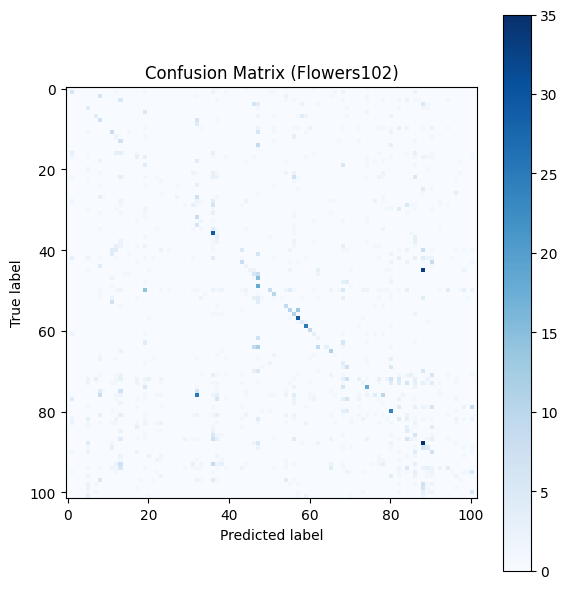

In [47]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Confusion Matrix 계산
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Flowers102)")
plt.colorbar()
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.show()


In [37]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix

def topk_accuracy(probs, y_true, k=5):
    topk = np.argpartition(-probs, k-1, axis=1)[:, :k]
    return np.any(topk == y_true[:, None], axis=1).mean()

metrics = {}
metrics["acc"] = float(accuracy_score(y_true, y_pred))
for avg in ["micro", "macro", "weighted"]:
    p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=avg, zero_division=0)
    metrics[f"precision_{avg}"] = float(p)
    metrics[f"recall_{avg}"]    = float(r)
    metrics[f"f1_{avg}"]        = float(f1)
metrics["top5_acc"] = float(topk_accuracy(probs, y_true, k=5))
metrics


{'acc': 0.199,
 'precision_micro': 0.199,
 'recall_micro': 0.199,
 'f1_micro': 0.199,
 'precision_macro': 0.1589998453341541,
 'recall_macro': 0.2026206726273066,
 'f1_macro': 0.13345332700162782,
 'precision_weighted': 0.21418824481558826,
 'recall_weighted': 0.199,
 'f1_weighted': 0.14574057147285546,
 'top5_acc': 0.462}

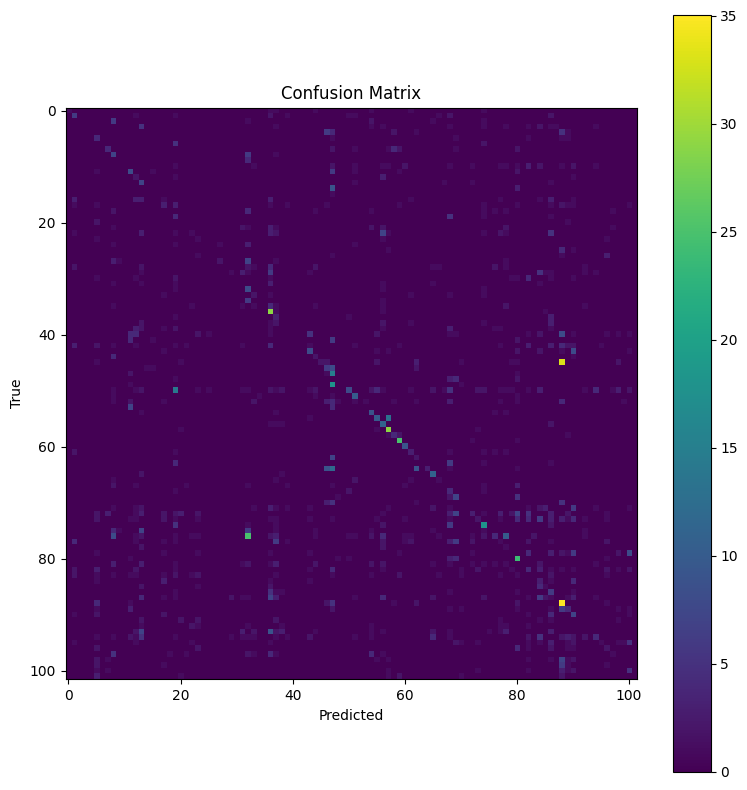

In [38]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)
fig = plt.figure(figsize=(8,8))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.tight_layout()
plt.show()


Worst 10: [(np.int64(3), np.float64(0.0)), (np.int64(2), np.float64(0.0)), (np.int64(6), np.float64(0.0)), (np.int64(4), np.float64(0.0)), (np.int64(15), np.float64(0.0)), (np.int64(14), np.float64(0.0)), (np.int64(10), np.float64(0.0)), (np.int64(9), np.float64(0.0)), (np.int64(24), np.float64(0.0)), (np.int64(25), np.float64(0.0))]
Best  10: [(np.int64(60), np.float64(1.0)), (np.int64(59), np.float64(0.9259259259259259)), (np.int64(57), np.float64(0.90625)), (np.int64(36), np.float64(0.90625)), (np.int64(47), np.float64(0.7894736842105263)), (np.int64(65), np.float64(0.7857142857142857)), (np.int64(32), np.float64(0.7272727272727273)), (np.int64(54), np.float64(0.6923076923076923)), (np.int64(56), np.float64(0.6875)), (np.int64(80), np.float64(0.6857142857142857))]


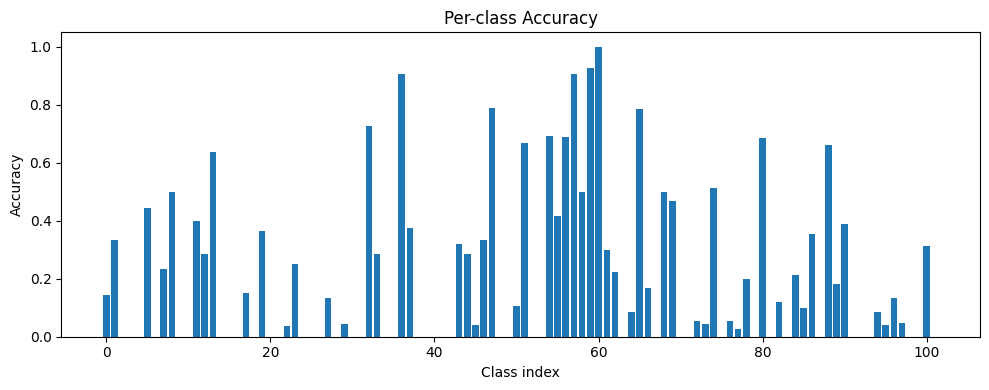

In [40]:
num_classes = probs.shape[1]
per_total   = np.zeros(num_classes, dtype=int)
per_correct = np.zeros(num_classes, dtype=int)

for t, p in zip(y_true, y_pred):
    per_total[t] += 1
    if t == p:
        per_correct[t] += 1

per_acc = np.divide(per_correct, np.maximum(per_total, 1))

# 하위 10개 클래스
worst_idx = np.argsort(per_acc)[:10]
best_idx  = np.argsort(-per_acc)[:10]
print("Worst 10:", list(zip(worst_idx, per_acc[worst_idx])))
print("Best  10:", list(zip(best_idx, per_acc[best_idx])))

import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.bar(range(len(per_acc)), per_acc)
plt.title("Per-class Accuracy")
plt.xlabel("Class index")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.show()


In [44]:
import sys
!{sys.executable} -m pip install pandas

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 2.1 MB/s  0:00:05 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [pandas]2m1/2 [pandas]


In [46]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

acc = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

df_metrics = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1-score"],
    "Score": [acc, precision, recall, f1]
})

print(df_metrics)
df_metrics


      Metric     Score
0   Accuracy  0.199000
1  Precision  0.214188
2     Recall  0.199000
3   F1-score  0.145741


,Metric,Score
0,Accuracy,0.199000
1,Precision,0.214188
2,Recall,0.199000
3,F1-score,0.145741
